In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Load data from text file
Status = np.loadtxt("Status_2024_04_30.txt", dtype=int)  # Specify dtype if known, for efficiency
Target = np.loadtxt("Target_2024_04_30.txt", dtype=float).T

In [3]:
N=Status.shape[0]

In [4]:
Y_train=Status[:int(N/2),-1]
Y_test=Status[int(N/2):int(0.75*N),-1]
Y_val=Status[int(0.75*N):,-1]
print(Y_train.shape,Y_test.shape,Y_val.shape)

Target_train=torch.tensor(Target[:int(N/2),:]).float()
Target_test=torch.tensor(Target[int(N/2):int(0.75*N),:]).float()
Target_val=torch.tensor(Target[int(0.75*N):,:]).float()
print(Target_train.shape,Target_test.shape,Target_val.shape)

(50000,) (25000,) (25000,)
torch.Size([50000, 10]) torch.Size([25000, 10]) torch.Size([25000, 10])


Notice that:
1. Each row of above X matrice is the vector of status of node 1 to node T
2. Each row of above Y is the status of node T+1

Then we need to construct word embedding and positional encoding

$$\tilde{X}^T=\begin{bmatrix}
    e_{s_1}& e_{s_2}&\cdots&e_{s_T}\\
    e_1&e_2&\cdots&e_T
\end{bmatrix}=\begin{bmatrix}
    \mathcal{E}_{s_{1:T}}\\
    \mathbb{I}_{T}
\end{bmatrix}$$

Generate $\mathbb{I}_{T}$ and $\mathcal{E}_{s_{1:T}}$

The input of Transformer should be $\tilde{X}^T$ and the output is $\pi(s'|s_T)$

#### Construct the input

In [49]:
S=10
T=20

#number of random sequence


I_S=np.identity(S)
I_t=np.identity(T)

#(iter,S+T,T)
X_tilde_T=np.empty((N,S+T,T))


for i in range(N):

    epsilon_1_T=np.zeros((S,T))

    #print(T)

    for k in range(T):
        epsilon_1_T[:,int(k)]=I_S[:,int(Status[i,int(k)])]

    #print(Status[0])

    X_tilde_T[i]=np.concatenate((epsilon_1_T,I_t),axis=0)


X_tilde=X_tilde_T.transpose(0,2,1)

X_train_tilde=torch.tensor(X_tilde[:int(N/2)])
X_test_tilde=torch.tensor(X_tilde[int(N/2):int(0.75*N)])
X_val_tilde=torch.tensor(X_tilde[int(0.75*N):])

batch_size=int(N/2)
train_dataset=TensorDataset(torch.tensor(X_train_tilde).float(),torch.tensor(Target_train).float())
train_data=DataLoader(train_dataset,batch_size=batch_size)

test_dataset=TensorDataset(torch.tensor(X_test_tilde).float(),torch.tensor(Target_test).float())
test_data=DataLoader(test_dataset,batch_size=batch_size)

/var/folders/pz/p8qzlrz11ndgpdncscl39lg80000gn/T/ipykernel_95419/3529077617.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset=TensorDataset(torch.tensor(X_train_tilde).float(),torch.tensor(Target_train).float())
/var/folders/pz/p8qzlrz11ndgpdncscl39lg80000gn/T/ipykernel_95419/3529077617.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset=TensorDataset(torch.tensor(X_test_tilde).float(),torch.tensor(Target_test).float())


In [50]:
a, a_label = next(iter(train_data))

In [51]:
# 打印出一个批次的数据大小
print(a.shape)
print(a_label.shape)

torch.Size([50000, 20, 30])
torch.Size([50000, 10])


#### Construct the target

In [52]:
S=10
T=20

import torch

# Example of defining a matrix
total_matrix_A_1 = torch.randn(int(S+T), int(S+T), requires_grad=True)
total_matrix_A_2 = torch.randn(int(2*S+2*T), int(2*S+2*T), requires_grad=True)
W_tilde = torch.randn(int(S), int(4*S+4*T), requires_grad=True)


# Define a mask where True means trainable
mask_A_1 = torch.tensor([[True if (i in range(S,int(S+T))  and  j in range(int(S),int(S+T))) else False for j in range(int(S+T))] for i in range(int(S+T))])
mask_A_2 = torch.tensor([[True if (i in range(0,S)  and  j in range(int(S+T),int(2*S+T))) else False for j in range(int(2*S+2*T))] for i in range(int(2*S+2*T))])
mask_W = torch.tensor([[True if (j in range(int(2*S+2*T),int(3*S+2*T))) else False for j in range(int(4*S+4*T))]])
mask_W_T = torch.tensor([[True if (j in range(int(2*S+2*T),int(3*S+2*T))) else False for j in range(int(4*S+4*T))]]).T

# Hook to apply the mask to the gradients
def apply_mask_1(grad):
    return grad * mask_A_1.type_as(grad)

def apply_mask_2(grad):
    return grad * mask_A_2.type_as(grad)

def apply_mask_W(grad):
    return grad * mask_W.type_as(grad)

def apply_mask_W_T(grad):
    return grad * mask_W_T.type_as(grad)

# Attach the hook
total_matrix_A_1.register_hook(apply_mask_1)

total_matrix_A_2.register_hook(apply_mask_2)

W_tilde.register_hook(apply_mask_W)

# output_3 = W_tilde.sum()
# output_3.backward()
# print(W_tilde.grad[:,int(2*S+2*T-1):int(3*S+2*T+1)])



# # Example usage in a dummy forward pass
# output_2 = total_matrix_A_2.sum()
# output_2.backward()



# # Set print options
# torch.set_printoptions(threshold=10_000)
# # Check gradients
# print(total_matrix_A_2.grad)

# output_1 = total_matrix_A_1.sum()
# output_1.backward()
# print(total_matrix_A_1.grad[10:])


In [53]:
# # Define a mask where True means trainable
# grad_mask_A_1 = torch.tensor([[True if (i in range(S,int(S+T))  and  j in range(int(S),int(S+T))) else False for j in range(int(S+T))] for i in range(int(S+T))])
# grad_mask_A_2 = torch.tensor([[True if (i in range(0,S)  and  j in range(int(S+T),int(2*S+T))) else False for j in range(int(2*S+2*T))] for i in range(int(2*S+2*T))])

# # Hook to apply the mask to the gradients
# def apply_mask_1(grad):
#     return grad * grad_mask_A_1.type_as(grad)

# def apply_mask_2(grad):
#     return grad * grad_mask_A_2.type_as(grad)


$$
\begin{equation*}
    \begin{split}
        \tilde A^{(1)}&=\begin{bmatrix}
            0_{S\times S} & 0_{S\times T}\\
            0_{T\times S} & A^{(1)}_1
        \end{bmatrix}\\
        % \tilde A_2^{(1)}&=\begin{bmatrix}
        %     0_{S\times S} & 0_{S\times T}\\
        %     0_{T\times S} & A^{(1)}_2
        % \end{bmatrix}\\
        \tilde A^{(2)}&=\begin{bmatrix}
            0_{S\times S} & 0_{S\times T} & A^{(2)} & 0_{S\times T}\\
            0_{T\times S} & 0_{T\times T} & 0_{T\times S} & 0_{T\times T}\\
            0_{S\times S} & 0_{S\times T} & 0_{S\times S} & 0_{S\times T}\\
            0_{T\times S} & 0_{T\times T} & 0_{T\times S} & 0_{T\times T}\\
        \end{bmatrix}\\
    \end{split}
\end{equation*}
$$

$$
attn(h;A)=\mathcal{S}(MASK(hAh^T))h
$$

$$
\underset{T\times (S+T)}{h^{0}}=\tilde{X}=\begin{bmatrix}
    e_{s_1}& e_{s_2}&\cdots&e_{s_T}\\
    e_1&e_2&\cdots&e_T
\end{bmatrix}^T
$$

$$
\underset{T\times (1+m_\ell)(S+T)}{h^{(\ell)}}=\bigl[h^{(\ell-1)},attn(h^{(\ell-1)};\widetilde{A}^{(\ell)}_1),\cdots,attn(h^{(\ell-1)};\widetilde{A}^{(\ell)}_1)\bigr]
$$

$$
\widetilde{TF}_{\tilde\theta}(S_{1:T})=h^{(L)}\widetilde {W}_O^T
$$

$$
dim(\widetilde {W}_O)=S\times (1+m_2)(S+T)
$$

In [54]:
# total_matrix_A_1 = torch.zeros(int(S+T), int(S+T), requires_grad=True)
# total_matrix_A_1.register_hook(apply_mask_1)

# total_matrix_A_1=total_matrix_A_1.float()

# total_matrix_A_2 = torch.zeros(int(2*S+2*T), int(2*S+2*T), requires_grad=True)
# total_matrix_A_2.register_hook(apply_mask_2)

# total_matrix_A_2=total_matrix_A_2.float()

# W_tilde = torch.zeros(int(S), int(4*S+4*T), requires_grad=True)
# W_tilde.register_hook(apply_mask_W)

# W_tilde=W_tilde.float()
# W_tilde_T=W_tilde.T

In [55]:
mask_layer_1=torch.triu(torch.ones(T, T, dtype=torch.bool), diagonal=1)

class Attention_1(nn.Module):
    def __init__(self):
        super(Attention_1, self).__init__()

        #Random initialize the matrix A_1
        # self.total_matrix_A_1 = torch.zeros(int(S+T), int(S+T), requires_grad=True)
        # self.total_matrix_A_1 = nn.Linear(int(S+T),int(S+T),bias=False)
        # self.total_matrix_A_1 = nn.Parameter(torch.zeros(int(S+T), int(S+T)))

        self.trainable_part = nn.Parameter(torch.zeros(T, T))
        self.non_trainable_part_1 = torch.zeros(S, int(S+T), requires_grad=False)
        self.non_trainable_part_2 = torch.zeros(T, S, requires_grad=False)

    def forward(self, h_0,attn_mask):
        # A_1=self.total_matrix_A_1.register_hook(apply_mask_1)
        # self.total_matrix_A_1.register_hook(apply_mask_1)

        total_matrix_A_1=torch.cat((self.non_trainable_part_2,self.trainable_part),dim=1)
        total_matrix_A_1=torch.cat((self.non_trainable_part_1,total_matrix_A_1),dim=0)

        h_0=h_0.float()

        total_matrix_A_1=total_matrix_A_1.unsqueeze(0)
        total_matrix_A_1=total_matrix_A_1.repeat(h_0.shape[0],1,1)

        # print(total_matrix_A_1.shape, h_0.shape)

        scores = torch.bmm(h_0, total_matrix_A_1) 

        scores = torch.bmm(scores,h_0.transpose(1,2))
        # print(scores.shape)

        attn_mask = attn_mask.unsqueeze(0)
        attn_mask = attn_mask.repeat(scores.shape[0],1,1)

        

        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        #row-wise softmax
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.bmm(attn, h_0)
        # print('layer 1 output shape: ',context.shape)

        return context #, attn



class Attention_2(nn.Module):
    def __init__(self):
        super(Attention_2, self).__init__()

        #Random initialize the matrix A_2
        # self.total_matrix_A_2 = torch.zeros(int(2*S+2*T), int(2*S+2*T), requires_grad=True)
        # self.total_matrix_A_2 = nn.Linear(int(2*S+2*T),int(2*S+2*T),bias=False)
        # self.total_matrix_A_2 = nn.Parameter(torch.zeros(int(2*S+2*T), int(2*S+2*T)))
        self.trainable_part = nn.Parameter(torch.zeros(S, S))
        self.non_trainable_part_1 = torch.zeros(S, int(S+T), requires_grad=False)
        self.non_trainable_part_2 = torch.zeros(S, T, requires_grad=False)
        self.non_trainable_part_3 = torch.zeros(2*T+S, 2*S+2*T, requires_grad=False)

    def forward(self, h_1):
        # self.total_matrix_A_2.register_hook(apply_mask_2)
        total_matrix_A_2=torch.cat((self.non_trainable_part_1,self.trainable_part,self.non_trainable_part_2),dim=1)
        total_matrix_A_2=torch.cat((total_matrix_A_2,self.non_trainable_part_3),dim=0)
        
        h_1=h_1.float()
        
        total_matrix_A_2=total_matrix_A_2.unsqueeze(0)
        total_matrix_A_2=total_matrix_A_2.repeat(h_1.shape[0],1,1)
        #print("total_matrix_A_2_shape: ",total_matrix_A_2.shape)

        scores = torch.bmm(h_1, total_matrix_A_2) 
        scores = torch.bmm(scores,h_1.transpose(1,2))
        #row-wise softmax
        
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.bmm(attn, h_1)
        #print('layer 2 output shape: ',context.shape)
        
        return context #, attn


class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.attention_1 = Attention_1()
        self.attention_2 = Attention_2()
        # self.linear = nn.Linear(2*S+2*T, 1)
        # self.W_tilde_T = nn.Parameter(torch.zeros(int(4*S+4*T), int(S)).float())
        self.trainable_part = nn.Parameter(torch.zeros(S, S))
        self.non_trainable_part_1 = torch.zeros((2*S+2*T), S, requires_grad=False)
        self.non_trainable_part_2 = torch.zeros((S+2*T), S, requires_grad=False)

    def forward(self, X):
        W_tilde_T=torch.cat((self.non_trainable_part_1,self.trainable_part,self.non_trainable_part_2),dim=0)

        attn_mask = mask_layer_1
        context_1 = self.attention_1(X, attn_mask)
        # print('h_0 shape: ',X.shape)
        
        h_1=torch.cat((X,context_1),dim=-1).float()
        # print("h_1 shape: ",h_1.shape) 
        # print(h_1.shape)
        
        context_2 = self.attention_2(h_1)
        h_2=torch.cat((h_1,context_2),dim=-1).float()
        # output = self.linear(h_1)
        
        output=torch.matmul(h_2,W_tilde_T)
        #print('output shape: ',output.shape)
        
        return output#, W_tilde_T#,attn_1,attn_2

In [56]:
# mask_layer_1=torch.triu(torch.ones(T, T, dtype=torch.bool), diagonal=1)

# class ScaledDotProductAttention(nn.Module):
#     def __init__(self):
#         super(ScaledDotProductAttention, self).__init__()
#         #Random initialize the matrix A_1
#         self.total_matrix_A_1 = torch.randn(int(S+T), int(S+T), requires_grad=True)


#     def forward(self, h_0, attn_mask):
#         A_1=self.total_matrix_A_1.register_hook(apply_mask_1)
        
#         scores = torch.matmul(h_0, A_1) 
#         scores = torch.matmul(scores,h_0.transpose)
#         scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
#         attn = nn.Softmax(dim=-1)(scores)
#         context = torch.matmul(attn, h_0)
#         return context, attn

In [72]:
net=Transformer()
# for param in net.parameters():
#     print(param)
#     param.requires_grad = False
#     print(param.requires_grad)

# net.attention_1.total_matrix_A_1[S:,S:].requires_grad = True
# net.attention_2.total_matrix_A_2[0:S,int(S+T):int(2*S+T)].requires_grad = True
# net.W_tilde_T[int(2*S+2*T):int(3*S+2*T),:].requires_grad = True

# print("Requires grad for A_1 section:", net.attention_1.total_matrix_A_1[S:, S:].requires_grad)
# print("Requires grad for A_2 section:", net.attention_2.total_matrix_A_2[0:S, int(S+T):int(2*S+T)].requires_grad)
# print("Requires grad for W_tilde_T section:", net.W_tilde_T[int(2*S+2*T):int(3*S+2*T), :].requires_grad)


# print("Total matrix A_1 shape:", net.attention_1.total_matrix_A_1.shape)
# print("Total matrix A_2 shape:", net.attention_2.total_matrix_A_2.shape)
# print("W_tilde_T shape:", net.W_tilde_T.shape)


criterion = nn.CrossEntropyLoss()

# trainable_params = [p for p in net.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

# # Assuming these are the tensors you want to optimize
# total_matrix_A_1 = torch.nn.Parameter(total_matrix_A_1)
# total_matrix_A_1.register_hook(apply_mask_1)
# total_matrix_A_2 = torch.nn.Parameter(total_matrix_A_2)
# total_matrix_A_2.register_hook(apply_mask_2)
# W_tilde_T = torch.nn.Parameter(W_tilde_T)
# W_tilde_T.register_hook(apply_mask_W_T)

# # Creating a list of parameters
# parameters = [total_matrix_A_1, total_matrix_A_2, W_tilde_T]

# Initializing the optimizer


In [73]:
# plt.imshow(parameters[0].detach().numpy(), cmap='hot')  # 'hot' is a popular colormap for heatmaps
# plt.colorbar()  # Show color scale

In [74]:
# # 开始训练
# losses = []
# acces = []
# eval_losses = []
# eval_acces = []

# for e in range(10):
#     train_loss = 0
#     train_acc = 0
#     net.train()
#     for im, label in train_data:
        
#         # im = Variable(im)
#         # label = Variable(label)
#         # 前向传播x

#         out = net(im)[:,-1,:]
#         loss = criterion(out, label)

#         # 反向传播
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         # 记录误差
        
#         train_loss += loss.item()
        
        
#     losses.append(train_loss / len(train_data))

In [75]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []

for e in range(10):
    train_loss = 0
    train_acc = 0
    net.train()
    for im, label in train_data:
        
        # im = Variable(im)
        # label = Variable(label)
        # 前向传播x

        out = net(im)[:,-1,:]
        loss = criterion(out, label)

        # 反向传播
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 记录误差
        
        train_loss += loss.item()
        
        
    losses.append(train_loss / len(train_data))

In [76]:
losses[0]

2.302584409713745

Text(0, 0.5, 'Loss')

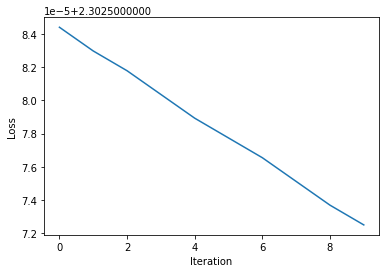

In [77]:
# Create a line plot of `losses`
plt.plot(losses)

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [78]:
losses[-1]

2.30257248878479

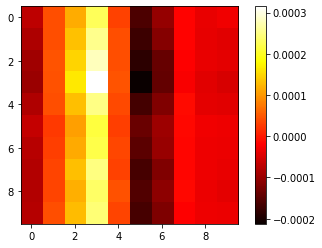

In [79]:
weight_fig=net.trainable_part.detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

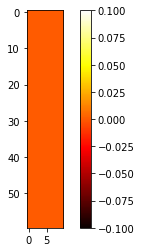

In [80]:
weight_fig=net.non_trainable_part_1.detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

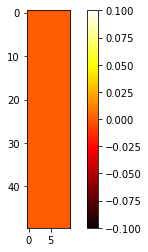

In [81]:
weight_fig=net.non_trainable_part_2.detach().numpy()
plt.imshow(weight_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

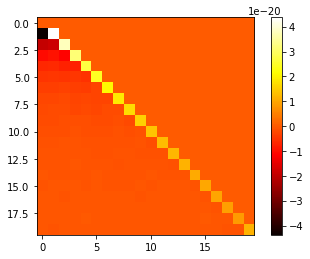

In [82]:
A_1_fig=net.attention_1.trainable_part.detach().numpy()
plt.imshow(A_1_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

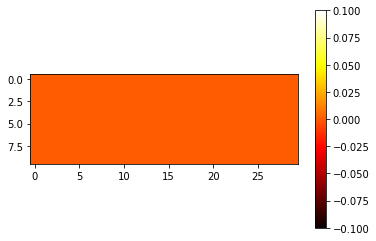

In [83]:
A_1_fig=net.attention_1.non_trainable_part_1.detach().numpy()
plt.imshow(A_1_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

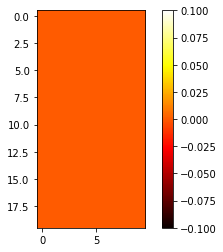

In [84]:
A_1_fig=net.attention_1.non_trainable_part_2.detach().numpy()
plt.imshow(A_1_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

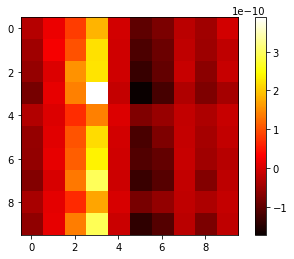

In [85]:
A_2_fig=net.attention_2.trainable_part.detach().numpy()
plt.imshow(A_2_fig, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

In [86]:
# for j in range(20):
#     loss=np.empty(X_train_tilde.shape[0])
#     for i in range(X_train_tilde.shape[0]):
#         temp=net(X_train_tilde[i])[0][-1,:].float()+1e-6
#         loss[i]=-torch.matmul(Target_train[i],torch.log(temp))

#     Loss=sum(loss)/iter
#     print(Loss)

In [87]:
loss=np.empty(X_train_tilde.shape[0])
for i in range(X_train_tilde.shape[0]):
    temp=net(X_train_tilde[i])[0][-1,:].float()+1e-6
    loss[i]=-torch.matmul(Target_train[i],torch.log(temp))

Loss=sum(loss)/iter
print(Loss)

RuntimeError: Expected 3-dimensional tensor, but got 2-dimensional tensor for argument #1 'batch1' (while checking arguments for bmm)